In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [50]:
nyc = pd.read_excel("nyc_crime_data.xls", header=0)  #manually removed the first 4 rows in the excel file containing metadata

In [51]:
#nyc.head()

In [52]:
# data rename 
nyc = nyc.rename(index=str, columns={'City': 'city', 'Population': 'population', 'Violent\ncrime': 'violent_crime',
       'Murder and\nnonnegligent\nmanslaughter' : 'murder_manslaughter',
       'Rape\n(legacy\ndefinition)2': 'rape',
       'Robbery': 'robbery_default', 'Aggravated\nassault': 'aggr_assault', 
        'Property\ncrime': 'property_crime', 'Burglary':'burglary',
       'Larceny-\ntheft': 'larceny_theft', 'Motor\nvehicle\ntheft': 'motor_theft'})

In [53]:
# Creating suggested feaures 

#nyc['pop_sqr'] = nyc.population**2
#nyc['murder'] = np.where(nyc['murder_manslaughter'] > 0,1,0)
#nyc['robbery_cat'] = np.where(nyc.robbery_default > 0, 1, 0)
#
# Deleting rape 1 column as all nan
nyc = nyc.drop(columns = ['Rape\n(revised\ndefinition)1'])


In [54]:
# Basic data cleaning 
nyc.describe()

,population,violent_crime,murder_manslaughter,rape,robbery_default,aggr_assault,property_crime,burglary,larceny_theft,motor_theft,Arson3
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,187.000
mean,40037.632,201.595,1.566,5.865,72.902,121.261,792.606,119.684,637.017,35.905,1.872
std,450037.368,2815.269,18.304,60.425,1031.033,1706.132,7659.725,924.949,6346.054,403.424,10.693
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,0.000,0.000,1.000,40.500,6.000,31.000,0.000,0.000
50%,7233.500,6.000,0.000,0.000,1.000,4.000,112.500,17.500,94.000,2.000,0.000
75%,18427.500,22.000,0.000,2.000,5.000,14.000,341.000,51.250,287.250,7.000,1.000
max,8396126.000,52384.000,335.000,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000,132.000


In [55]:
print(nyc.isnull().sum())   # list of NaNs 

nyc[nyc.city.str.contains('The')]
# index 348-350 . # the last three rows

nyc = nyc[:-3]

city                     0
population               3
violent_crime            3
murder_manslaughter      3
rape                     3
robbery_default          3
aggr_assault             3
property_crime           3
burglary                 3
larceny_theft            3
motor_theft              3
Arson3                 164
dtype: int64


In [56]:
#print(nyc.isnull().sum())  #nyc.isna().sum()  No null values except for Asson3 (161)

In [57]:
nyc.columns

Index(['city', 'population', 'violent_crime', 'murder_manslaughter', 'rape',
       'robbery_default', 'aggr_assault', 'property_crime', 'burglary',
       'larceny_theft', 'motor_theft', 'Arson3'],
      dtype='object')

(0, 800)

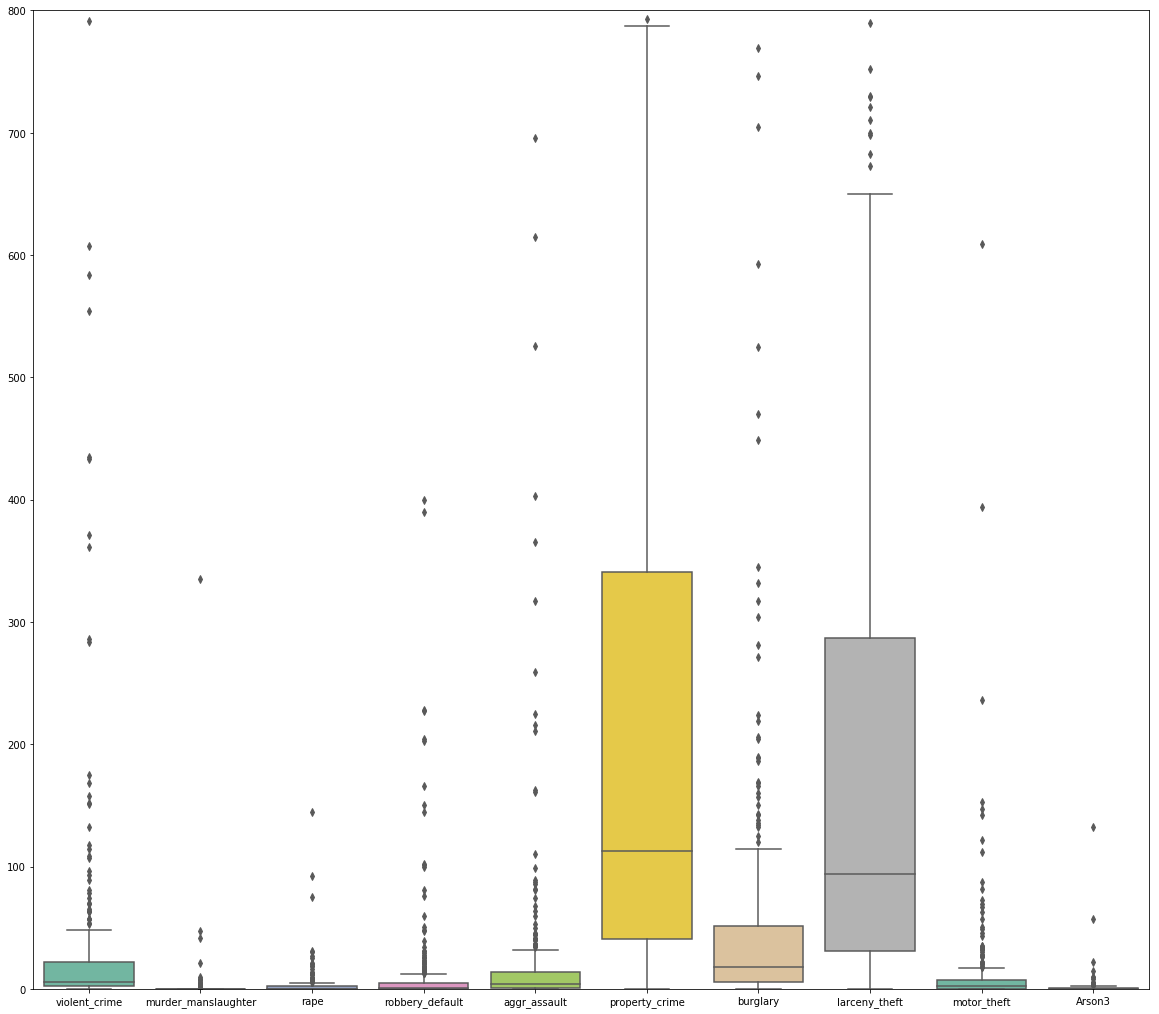

In [58]:
plt.figure(figsize=(20, 18))
sns.boxplot(data=nyc[[ 'violent_crime', 'murder_manslaughter', 'rape',
       'robbery_default', 'aggr_assault', 'property_crime', 'burglary',
       'larceny_theft', 'motor_theft', 'Arson3']], palette="Set2" )

#plt.ylim(0,5000)  #default shows few (6 in number) outliers after 5000
#plt.ylim(0,1000)  #default shows few outliers after 1000

plt.ylim(0,800)  #almost all values of these variables are concentrated under 500

# Among the variables 'property_Crime' is the quite frequent 

(0, 120)

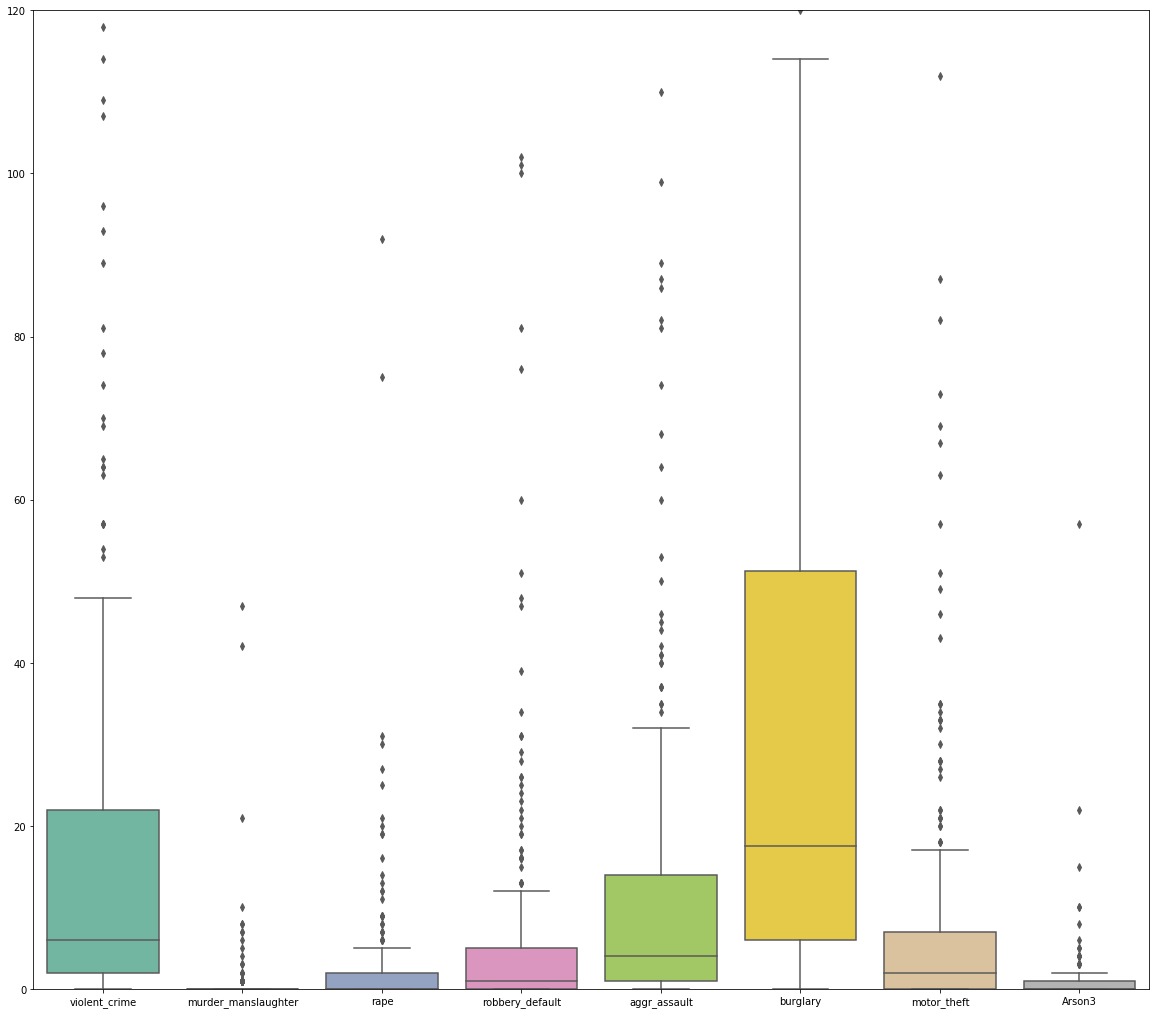

In [59]:
# Taking a closer look at the variables

plt.figure(figsize=(20, 18))
sns.boxplot(data=nyc[[ 'violent_crime', 'murder_manslaughter', 'rape',
       'robbery_default', 'aggr_assault', 'burglary',
       'motor_theft', 'Arson3']], palette="Set2" )

plt.ylim(0, 120)  #rest of the crimes are contained within 120 occurrences

In [60]:
# creating features - city to boroughs -- didn't find appropriate documentation - http://www.nysl.nysed.gov/genealogy/townlist.htm
#this doesn't have all names. 

In [61]:
#nyc.iloc[np.where(nyc.pop_sqr == nyc.pop_sqr.max())]  # NYC is the source for all outliers

According to the FBI's Uniform Crime Reporting [(here)](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/property-crime/property-crime-topic-page/propertycrimemain_final), property crime includes the offenses of burglary, larceny-theft, motor vehicle theft, and arson. The object of the theft-type offenses is the taking of money or property, but there is no force or threat of force against the victims. The property crime category includes arson because the offense involves the destruction of property; however, arson victims may be subjected to force. Therefore, it is expected that the property crime will be highly correlated with these variables. 

Multiple Linear Regression formula:

$$ property crime = \alpha + burglary + larceny/theft + motor theft + arson $$

                property_crime  burglary  larceny_theft  motor_theft  Arson3
property_crime           1.000     0.987          1.000        0.998   0.921
burglary                 0.987     1.000          0.983        0.991   0.952
larceny_theft            1.000     0.983          1.000        0.997   0.894
motor_theft              0.998     0.991          0.997        1.000   0.935
Arson3                   0.921     0.952          0.894        0.935   1.000


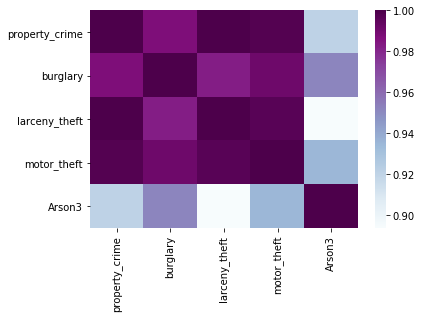

In [62]:
corr = nyc[['property_crime','burglary', 'larceny_theft', 'motor_theft', 'Arson3']].corr()

sns.heatmap(corr, cmap='BuPu', linecolor='white')
print(corr)

As expected, property crime is highly correlated with larceny and theft, however, it is not corelated with arson. 

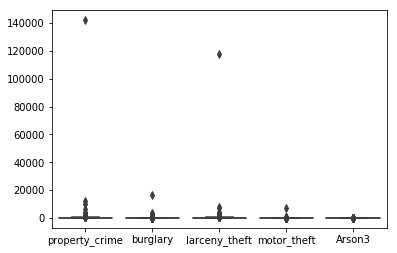

In [63]:
sns.boxplot(data=nyc[['property_crime','burglary', 'larceny_theft', 'motor_theft', 'Arson3']])

In [64]:
# Data cleaning: All the variables have outliers. 

# Winsorizing the outliers. Outliers in the both ends are substituted with a quantile value given by the function 
# The (limits[0])th lowest values are set to the (limits[0])th percentile, and the (limits[1])th highest values are set to the (limits[1])th percentile. 
from scipy import stats

nyc[['property_crime','burglary', 'larceny_theft', 'motor_theft', 'Arson3']]

import scipy

nyc['property_crime'] = scipy.stats.mstats.winsorize(nyc['property_crime'], limits=[0,0.03])
nyc['burglary'] = scipy.stats.mstats.winsorize(nyc['burglary'], limits=[0,0.03])
nyc['larceny_theft'] = scipy.stats.mstats.winsorize(nyc['larceny_theft'], limits=[0,0.03])
nyc['motor_theft'] = scipy.stats.mstats.winsorize(nyc['motor_theft'], limits=[0,0.03])
nyc['Arson3'] = scipy.stats.mstats.winsorize(nyc['Arson3'], limits=[0,0.03])


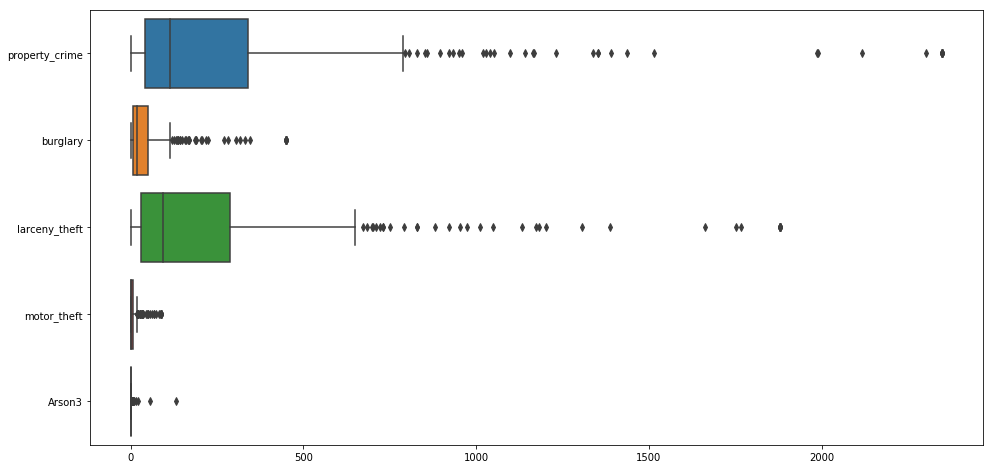

In [65]:
plt.figure(figsize=(16,8))

#sns.subplot(3,2,1)
sns.boxplot(data=nyc[['property_crime','burglary', 'larceny_theft', 'motor_theft', 'Arson3']], orient='h')

In [66]:
# Instantiate and fit the first version of the model.
regr = linear_model.LinearRegression()
Y = nyc.property_crime.values.reshape(-1,1)
X = nyc[['burglary', 'larceny_theft', 'motor_theft']]
regr.fit(X, Y)

print('\nCoeffiicients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))



Coeffiicients: 
 [[1.03514399 0.98774906 1.07249876]]

Intercept: 
 [0.88265]

R-squared:
0.9989995532674184


Most likely such a high R-squared value is indicative of model overfitting, but as we will see in this model(?) /exercise, the chosen parameters are in fact explaining most of the variances of the model. 

Checking the accuracy of the model with cross-validation as what this does is to make 10-fold training and testing set in the during model training and testing, and returns the accuracies. The mean accuracy via cross-validation is a more validated indicator of the accuracy. 


In [67]:
# Adding cross-validation 

from sklearn.model_selection import cross_val_score

regr = linear_model.LinearRegression()

print(cross_val_score(regr, X, Y, cv=10))

print("Mean CV score: ", (cross_val_score(regr, X, Y, cv=10)).mean())

[0.99918433 0.99939991 0.99997552 0.99948924 0.99970378 0.99894265
 0.99905906 0.99936564 0.99893903 0.99595589]
Mean CV score:  0.9990015035816853


For an initial observation, this model looks __definitely overfitted__ as the r-squared value is 0.99. 

In [72]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = nyc.property_crime.values.reshape(-1,1)
X = nyc[['burglary', 'larceny_theft', 'motor_theft']]
regr.fit(X, Y)

print('\nCoeffiicients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))

print("10-k cross validation scores: \n", cross_val_score(regr, X, Y, cv=10))

print("Mean CV score: ", (cross_val_score(regr, X, Y, cv=10)).mean())



Coeffiicients: 
 [[1.03514399 0.98774906 1.07249876]]

Intercept: 
 [0.88265]

R-squared:
0.9989995532674184
10-k cross validation scores: 
 [0.99918433 0.99939991 0.99997552 0.99948924 0.99970378 0.99894265
 0.99905906 0.99936564 0.99893903 0.99595589]
Mean CV score:  0.9990015035816853


In [73]:
# Adding robbery as one of the predictors, 
#R-squared is still 1. 

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = nyc.property_crime.values.reshape(-1,1)
X = nyc[['burglary', 'larceny_theft', 'motor_theft', 'robbery_default']]
regr.fit(X, Y)

print('\nCoeffiicients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))

print("10-k cross validation scores: \n", cross_val_score(regr, X, Y, cv=10))

print("Mean CV score: ", (cross_val_score(regr, X, Y, cv=10)).mean())



Coeffiicients: 
 [[ 1.04587122  0.98713788  1.09941301 -0.00401261]]

Intercept: 
 [0.54494744]

R-squared:
0.9990591890322064
10-k cross validation scores: 
 [0.99920263 0.99943715 0.99997152 0.99954118 0.99974746 0.99908223
 0.83294854 0.99931993 0.99875739 0.99615204]
Mean CV score:  0.9824160082654549


In [74]:
#X.columns -
# still overfitted 

In [75]:
# Checking with other variables 

In [76]:
nyc[['violent_crime', 'murder_manslaughter', 'rape', 'Arson3']].isnull().sum()
# arson has 161 null 

# Filling NaNs in Arson with mean of the column
nyc.Arson3.fillna(nyc.Arson3.mean(), inplace = True)

In [77]:
nyc[['violent_crime', 'murder_manslaughter', 'rape', 'Arson3']].isnull().sum()
# arson has 161 null 

violent_crime          0
murder_manslaughter    0
rape                   0
Arson3                 0
dtype: int64

In [78]:
regr = linear_model.LinearRegression()
Y = nyc.property_crime.values.reshape(-1,1)
X = nyc[['violent_crime', 'murder_manslaughter', 'rape', 'Arson3']]
regr.fit(X, Y)

print('\nCoeffiicients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))  # the R^2 is .99. This is probably still overfitting. 

print("10-k cross validation scores: \n", cross_val_score(regr, X, Y, cv=10))

print("Mean CV score: ", (cross_val_score(regr, X, Y, cv=10)).mean())



Coeffiicients: 
 [[  -0.71726311 -122.2716077    72.63425885   18.96695486]]

Intercept: 
 [193.69603476]

R-squared:
0.4380961973105269
10-k cross validation scores: 
 [ 4.17701464e-01  2.12491115e-01  8.12071567e-02  3.33530047e-01
 -1.87170004e+00  1.81137783e-01 -7.41728449e+02 -2.17915415e-03
  5.97945944e-01  3.76365374e-01]
Mean CV score:  -74.14019492095534


Other uncorrelated variables decreases model accuracy. 


Let's now checking the linear relationship in the variables of interest for the purpose of checking the assumptions.  

Text(0.5,1,'Robbery')

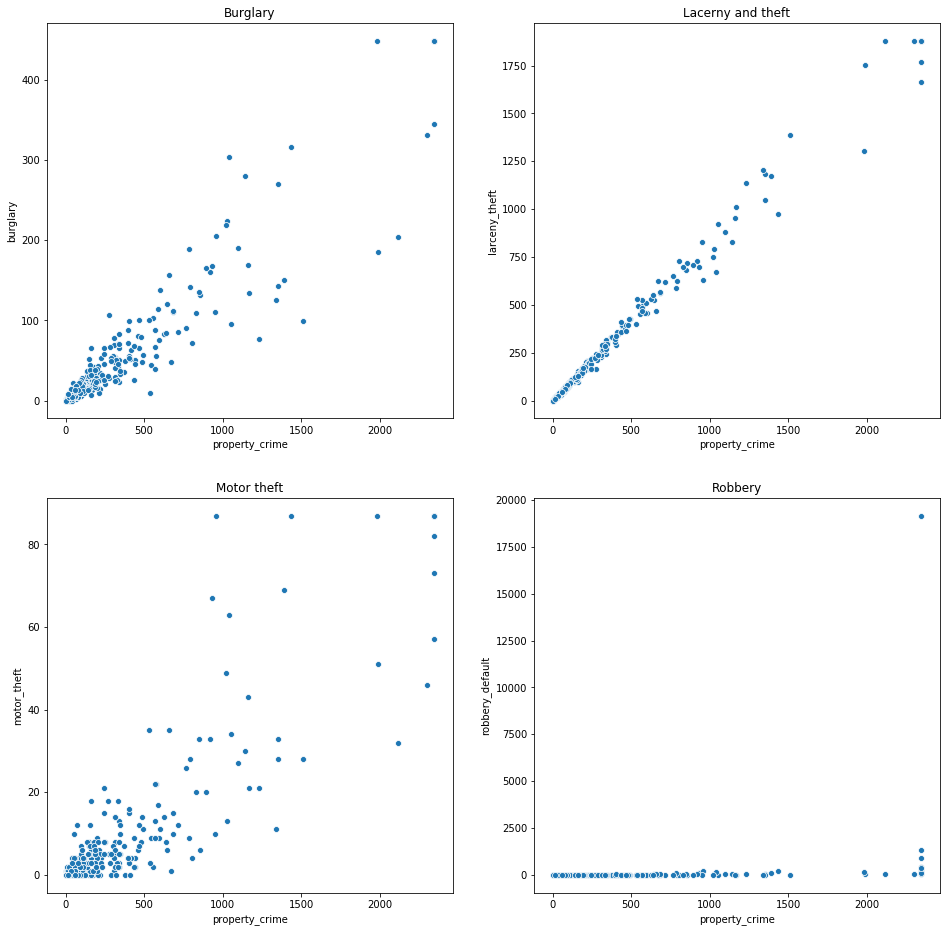

In [79]:
plt.figure(figsize=(16,16))


#'burglary', 'larceny_theft', 'motor_theft', 'robbery_default'

#Burglary
plt.subplot(2, 2, 1)
sns.scatterplot(nyc.property_crime, nyc.burglary)
plt.title('Burglary')

#Lacerny
plt.subplot(2, 2, 2)
sns.scatterplot(nyc.property_crime, nyc.larceny_theft)
plt.title('Lacerny and theft')

# Motor theft
plt.subplot(2, 2, 3)
sns.scatterplot(nyc.property_crime, nyc.motor_theft)
plt.title('Motor theft')

# Robbery
plt.subplot(2, 2, 4)
sns.scatterplot(nyc.property_crime, nyc.robbery_default)
plt.title('Robbery')


# NONE of the relationships are linear 
# For the first pop-pop_squared we can do a square_root 

#follow the following reference 

    

It seems almost all the relationships, exceot Robbery, are linear.


[independent variable transformation](https://statswithcats.wordpress.com/2010/11/21/fifty-ways-to-fix-your-data)

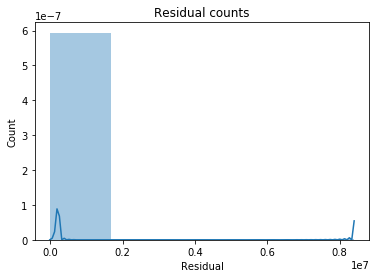

In [80]:
# check residual 

predicted = regr.predict(X).ravel()
actual = nyc.population

residual = actual - predicted

sns.distplot(residual, bins=5)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# residual is normally distributed. not good - the model is following the errors too closely. 

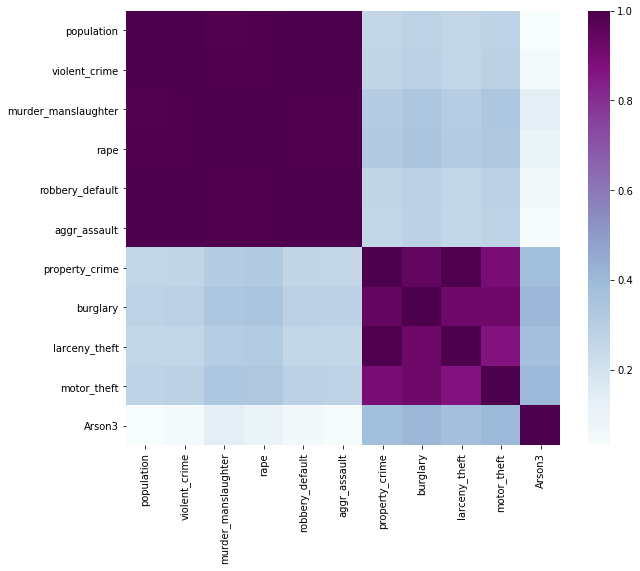

In [81]:
# Check multicollinearity 
plt.figure(figsize=(10,8))
sns.heatmap(nyc.corr(), cmap='BuPu', square=True)


This exercise shows the important effects of outliers in predicting the modes. The variables in the lower half of the corrplot had extreme high correlation. Now, after outlier removal, we have more information.

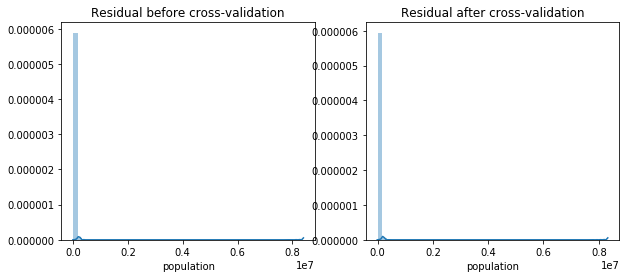

In [82]:
# Now try residual 

from sklearn.model_selection import cross_val_predict
predicted_1 = cross_val_predict(regr, X, Y).ravel()
actual_1 = nyc.population

residual_1 = actual_1 - predicted_1

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.distplot(residual)
plt.title("Residual before cross-validation")

plt.subplot(1,2,2)
sns.distplot(residual_1)
plt.title("Residual after cross-validation")
plt.show()

In [83]:
regr = linear_model.LinearRegression()
Y = nyc.property_crime.values.reshape(-1,1)
X = nyc[['burglary', 'larceny_theft', 'motor_theft']]
regr.fit(X, Y)

print('\nCoeffiicients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))

print("10-k cross validation scores: \n", cross_val_score(regr, X, Y, cv=10))

print("Mean CV score: ", (cross_val_score(regr, X, Y, cv=10)).mean())


Coeffiicients: 
 [[1.03514399 0.98774906 1.07249876]]

Intercept: 
 [0.88265]

R-squared:
0.9989995532674184
10-k cross validation scores: 
 [0.99918433 0.99939991 0.99997552 0.99948924 0.99970378 0.99894265
 0.99905906 0.99936564 0.99893903 0.99595589]
Mean CV score:  0.9990015035816853


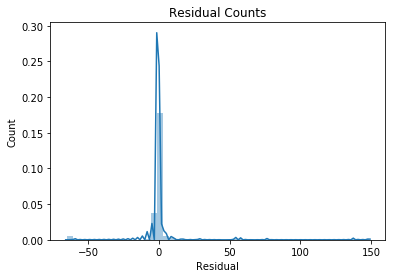

In [84]:
# prediction 

predicted  = regr.predict(X).ravel()
actual= nyc.property_crime

residual = actual - predicted

sns.distplot(residual, bins=50)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

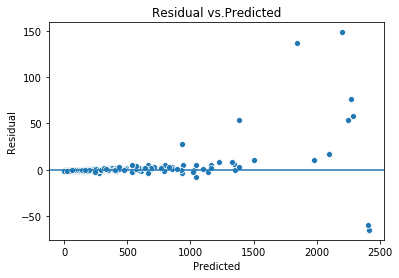

In [85]:
sns.scatterplot(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs.Predicted')
plt.show()

It seems like a pretty good fit! 

Earlier, our regression formula was: 

$$ property crime = \alpha + burglary + larceny/theft + motor theft + arson $$

Now, modifying the formula to be the follwoing: 

$$ property crime = \alpha + burglary + larceny/theft + motor theft $$

## Additional components and testing:

linear models and p-values, with the statsmodel 

In [86]:
linear_formula = 'property_crime ~ burglary+larceny_theft+motor_theft'

lm = smf.ols(formula=linear_formula, data=nyc).fit()

In [87]:
# coefficients 

lm.params

Intercept       0.883
burglary        1.035
larceny_theft   0.988
motor_theft     1.072
dtype: float64

In [88]:
lm.pvalues

Intercept       0.396
burglary        0.000
larceny_theft   0.000
motor_theft     0.000
dtype: float64

In [89]:
lm.rsquared

0.9989995532674184

In [90]:
lm.conf_int()

,0,1
Intercept,-1.162,2.927
burglary,0.972,1.098
larceny_theft,0.977,0.999
motor_theft,0.827,1.318


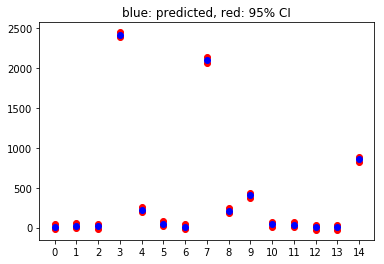

In [91]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


# Use wls_prediction_std to build confidence intervals
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()